In [6]:
# machine learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm

# Visualization of data
import matplotlib.pyplot as plt

import os
import mne
import math

import numpy as np

# Connects to the database
import mysql.connector

# Getting data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.).pick_types(meg='mag', eeg=False, stim=True, eog=True)
raw.load_data()

# Clean data
Clean_raw = mne.io.read_raw_fif("Clean_raw.fif")
Clean_raw.load_data()


Opening raw data file C:\Users\shamd\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Reading 0 ... 9009  =      0.000 ...    59.999 secs...
Opening raw data file Clean_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 15459 =     42.956 ...   102.954 secs
Ready.
Reading 0 ... 9009  =      0.000 ...    59.999 secs...


<Raw | Clean_raw.fif, 102 x 9010 (60.0 s), ~10.0 MB, data loaded>

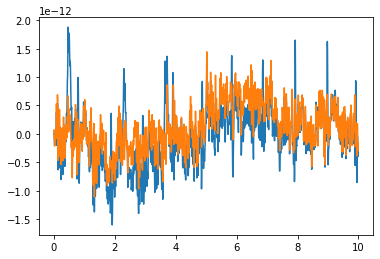

In [2]:
sampling_freq = raw.info['sfreq']
start_stop_seconds = np.array([0, 10])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
raw_selection = raw['MEG 1411', start_sample:stop_sample]
Clean_raw_selection = Clean_raw['MEG 1411', start_sample:stop_sample]

n_x = raw_selection[1]   # time
n_y = raw_selection[0].T # data array transposed
plt.plot(n_x, n_y)
# Plotting Clean signal (Orange)
c_x = Clean_raw_selection[1]
c_y = Clean_raw_selection[0].T
plt.plot(c_x, c_y)

num_of_samples = 10000
# Containers for samples.
n_samples = []
c_samples = []
x_s = [] # array of x values
y_s = [] # array of y values

for j in range(0,num_of_samples):
    for i in range(0,1501):
        x_s.append(n_x[i])
        y_s.append(n_y[i][0])
        
    # Append to noisy Samples
    n_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array 
    
    
        
    for k in range(0,1501):
        x_s.append(c_x[k])
        y_s.append(c_y[k][0])
        
    # Append to clean Samples
    c_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array
    


In [3]:
print("Going to next computations...\n")
n_samples = np.array(n_samples)
c_samples = np.array(c_samples)

x_val_noisy, y_val_noisy = n_samples[:,0], n_samples[:,1]
x_val_pure, y_val_pure = c_samples[:,0], c_samples[:,1]

# Reshape Data and utilize Binary Cross Entropy
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  


Going to next computations...



In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
# Model Configuration
input_shape = (1501,1)
batch_size = 150
no_epochs = 10
train_test_split = 0.3
validation_split = 0.3
verbosity = 1
max_norm_value = 2.0

# Create the model
model = Sequential()
model.add(Conv1D(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(128, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

# Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

Epoch 1/10
33/33 [==============================] - 39s 1s/step - loss: 0.6776 - val_loss: 0.6635
Epoch 2/10
33/33 [==============================] - 36s 1s/step - loss: 0.6590 - val_loss: 0.6559
Epoch 3/10
33/33 [==============================] - 36s 1s/step - loss: 0.6549 - val_loss: 0.6540
Epoch 4/10
33/33 [==============================] - 36s 1s/step - loss: 0.6538 - val_loss: 0.6559
Epoch 5/10
33/33 [==============================] - 36s 1s/step - loss: 0.6536 - val_loss: 0.6523
Epoch 6/10
33/33 [==============================] - 36s 1s/step - loss: 0.6517 - val_loss: 0.6512
Epoch 7/10
33/33 [==============================] - 36s 1s/step - loss: 0.6508 - val_loss: 0.6503
Epoch 8/10
33/33 [==============================] - 36s 1s/step - loss: 0.6498 - val_loss: 0.6493
Epoch 9/10
33/33 [==============================] - 36s 1s/step - loss: 0.6499 - val_loss: 0.6490
Epoch 10/10
33/33 [==============================] - 37s 1s/step - loss: 0.6486 - val_loss: 0.6483


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1499, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, 1497, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1499, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1501, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, 1501, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

1/1 [==============================] - 0s 340ms/step


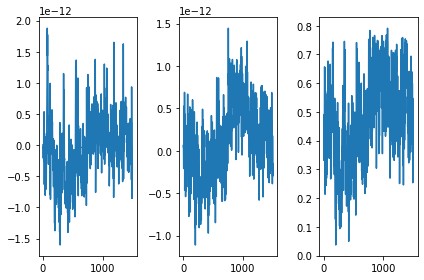

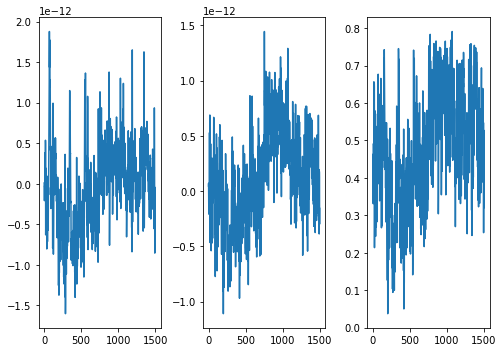

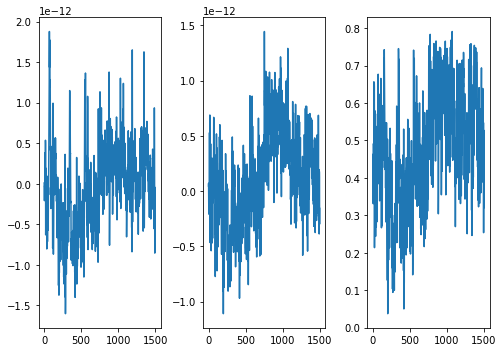

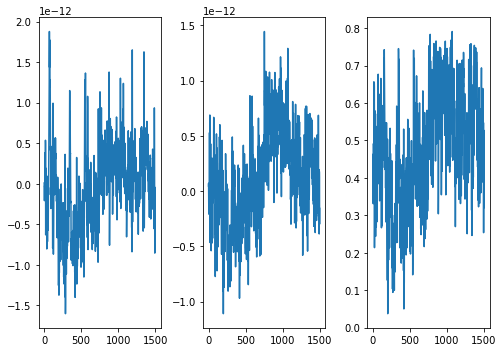

In [6]:
# Generate reconstructions
num_reconstructions = 4
samples = noisy_input_test[:num_reconstructions]
reconstructions = model.predict(samples)


# Plot reconstructions
for i in np.arange(0, num_reconstructions):
    # Prediction index
    prediction_index = i + percentage_training
    # Get the sample and the reconstruction
    original = y_val_noisy[prediction_index]
    pure = y_val_pure[prediction_index]
    reconstruction = np.array(reconstructions[i])
    # Matplotlib preparations
    fig, axes = plt.subplots(1, 3)
    # Plot sample and reconstruciton
    plt.rcParams["figure.figsize"] = (7,5)
    axes[0].plot(original)
    axes[1].plot(pure)
    axes[2].plot(reconstruction)
    fig.tight_layout()
    plt.show()

In [31]:
recarray = np.ravel(reconstruction)
print(recarray)

[0.45239937 0.46317625 0.43511122 ... 0.35514757 0.32018214 0.37054715]


In [5]:
import mysql.connector
# Connecting to the Database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
)

mycursor = mydb.cursor()

mycursor.execute("CREATE DATABASE IF NOT EXISTS Biomedical")

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="Biomedical"
)

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS Signals (ynoise DOUBLE(31,30), yclean DOUBLE(31,30), yrec FLOAT(9,8))")

recarray = np.ravel(reconstruction).tolist()
for i in range(0,len(y_val_noisy[0])):
    sql = "INSERT INTO signals (ynoise, yclean,yrec) VALUES (%s, %s, %s)"
    valone = y_val_noisy[0][i]
    valtwo = y_val_pure[0][i]
    valthree = recarray[i]
    val = [(valone,valtwo,valthree)]
    mycursor.executemany(sql, val)
    mydb.commit()

'\nrecarray = np.ravel(reconstruction).tolist()\nfor i in range(0,len(y_val_noisy[0])):\n    sql = "INSERT INTO signals (ynoise, yclean,yrec) VALUES (%s, %s, %s)"\n    valone = y_val_noisy[0][i]\n    valtwo = y_val_pure[0][i]\n    valthree = recarray[i]\n    val = [(valone,valtwo,valthree)]\n    mycursor.executemany(sql, val)\n    mydb.commit()\n'